In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import cv2

In [3]:
PATH = Path('../input')
OUT_PATH = Path('/kaggle/working')

# Data

In [4]:
def prepare_data(size='sm'):
    """Returns trn and tst dataframe with appropriate preparations"""
    
    orig = 'origframes'+size
    xtra = '2k19frames'+size
    
    # different datasets
    trn = sorted(os.listdir(PATH/orig/'train/'))
    tst = sorted(os.listdir(PATH/orig/'test/'))
    c92 = sorted(os.listdir(PATH/orig/'c92/'))
    c4 = sorted(os.listdir(PATH/xtra/'c4/'))
    c9 = sorted(os.listdir(PATH/xtra/'c9/'))
    c10 = sorted(os.listdir(PATH/xtra/'c10/'))

    # duplicate first images to maintain equality with target arrays
    trn = [trn[0]]+trn
    tst = [tst[0]]+tst
    c4 = [c4[0]]+c4
    c9 = [c9[0]]+c9
    c10 = [c10[0]]+c10
    c92 = [c92[0]]+c92

    # speeds
    trn_sp = np.loadtxt('../input/speed-texts/train.txt')
    c4_sp = np.loadtxt('../input/speed-texts/c4_speeds.txt')
    c9_sp = np.loadtxt('../input/speed-texts/c9_speeds.txt')
    c10_sp = np.loadtxt('../input/speed-texts/c10_speeds.txt')
    c92_sp = np.loadtxt('../input/speed-texts/c9_2_speeds.txt')

    # 25fps (2k19) vs 20fps (train) 
    # for 25fps: distance traveled btw frames should be 20% less (@ same speed) => need to reduce the speeds
    for i in [c4_sp,c9_sp,c10_sp,c92_sp]:
        i *= 0.8

    # prepend folder name to filename
    trn = [f'/{orig}/train/'+i for i in trn]
    tst = [f'/{orig}/test/'+i for i in tst]
    c92 = [f'/{orig}/c92/'+i for i in c92]
    c4 =  [f'/{xtra}/c4/'+i for i in c4]
    c9 =  [f'/{xtra}/c9/'+i for i in c9]
    c10 = [f'/{xtra}/c10/'+i for i in c10]

    # create dataframes
    fnames = trn+c4+c9+c10+c92
    speeds = np.concatenate([trn_sp,c4_sp,c9_sp,c10_sp,c92_sp])
    df = DataFrame({'filenames': fnames, 'labels': speeds})
    test_df = DataFrame({'filenames': tst})
    
    # add cross-flow traffic section of test_df into df
    cft = test_df[1175:1620].copy()
    cft['labels'] = 0.0
    
    # add highway section of test_df into df
    cft2 = test_df[3600:4200].copy()
    cft2['labels'] = 25.0

    df = pd.concat([df,cft,cft2], ignore_index=True)
    return df,test_df

In [5]:
df,test_df = prepare_data()
len(df),len(test_df)

(72673, 10798)

In [6]:
# suppress annoying scale_factor warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [7]:
tfms = ([flip_lr(p=0.5,use_on_y=False)],[])

In [10]:
def get_data(path,vdx=None,bs=100):
    return (ImageList.from_df(df, path)
        .split_none()   # calc final results w/ full training set
        #.split_by_idx(vdx)
        .label_from_df()
        .transform(tfms)
        .add_test(ImageList.from_df(test_df, path))
        .databunch(bs=bs)
       )

In [11]:
data = get_data(PATH)
data.show_batch(5, DatasetType.Train)

# Model

In [13]:
act_fn = nn.ReLU(inplace=True)

class Flatten(Module):
    def forward(self, x): return x.view(x.size(0), -1)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def noop(x): return x

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

class ResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1, drop=0.1):
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(stride, ceil_mode=True)
        self.drop = nn.Dropout2d(drop)

    def forward(self, x): return act_fn(self.drop(self.convs(x) + self.idconv(self.pool(x))))

def filt_sz(recep): return min(64, 2**math.floor(math.log2(recep*0.75)))

class XResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=3, c_out=1000, drop=0.1):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512] +[256]*(len(layers)-4)
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2, drop)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(block_szs[-1]*expansion, c_out),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride, drop):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1, drop)
              for i in range(blocks)])

def xresnet(expansion, n_layers, name, c_out=1000, pretrained=False, **kwargs):
    model = XResNet(expansion, n_layers, c_out=c_out, **kwargs)
    if pretrained: model.load_state_dict(model_zoo.load_url(model_urls[name]))
    return model

In [14]:
model = partial(xresnet, expansion=1, n_layers=[2,2,2,2,1,1], name='xresnet18_deep')  # w/ added dropout
# model = partial(xresnet, expansion=1, n_layers=[3,4,6,3,1,1], name='xresnet34_deep')

class Model(Module):
    def __init__(self):
        self.cnn = model(c_out=1, drop=0.3)
        
    def forward(self, x):
        x = self.cnn(x)
        return torch.clamp(x,0,30)

# Training

In [19]:
learn = Learner(data, Model(), loss_func=MSELossFlat(), path=OUT_PATH)
learn.fit_one_cycle(10, 1e-2)
# learn.fit(5, 1e-2) #; validation set: first/last 2000 of orig. train frames

# bs=100
# 4	0.845956	7.570271	00:25  original training set only
# 4	0.625646	7.289826	01:26  include 2k19 vids  (much higher test plot!!)  **
# 4	5.969658	9.487709	01:17  custom arch w/ dropout max 128 ch.
# 4	3.434698	6.231866	01:23  xresnet18_deep w/ dropout(0.2) after every ResBlock
# 4	2.026669	7.715620	01:22  xresnet18_deep w/ dropout(0.1) after every conv_layer
# 4	6.193273	7.183534	01:21  xresnet18_deep w/ dropout(0.5) after every ResBlock
# 4	4.633294	6.031477	01:21  "", 5cycles

# new data
# 4	5.615742	7.383484	01:21  xresnet18_deep w/ dropout(0.5) after every ResBlock
# 4	8.463151	12.401779	01:31  resnet34_deep ""
# 4	4.521659	6.734974	01:21  xresnet18_deep w/ dropout(0.4)
# 9	3.401432	6.263545	01:20  10cycle ""
# 4	6.728229	8.715267	01:26  xresnet18_deep w/ dropout(0.4) (no *.8)
# 4	4.781599	#na#    	01:26  xresnet18_deep w/ dropout(0.4), no validation split

# 4	4.014086	5.665481	01:24  xresnet18_deep w/ dropout(0.3)
# 4	4.174629	6.810672	01:25  "", wd=0.1
# 4	4.030526	6.275918	01:25  "", wd=.05
# 4	2.260775	6.336450	01:25  xresnet18_deep w/ dropout(0.1), wd=0.1
# 4	5.506297	7.539432	01:23  xresnet18_deep w/ dropout(0.3); fit_one_cycle(5,1e-1)

# sm
# 4	3.863745	#na#	01:25  xresnet18_deep w/ dropout(0.3), split_none()
# 9	2.787500	#na#	01:23  ""

epoch,train_loss,valid_loss,time
0,15.631994,#na#,02:31
1,10.968797,#na#,01:24
2,7.769820,#na#,01:24
3,6.575270,#na#,01:26
4,6.299894,#na#,01:26
5,4.815829,#na#,01:24
6,3.986796,#na#,01:25
7,3.349729,#na#,01:25


In [20]:
# increase size
df,test_df = prepare_data(size='md')
learn.data = get_data(PATH)

learn.fit_one_cycle(10, 1e-2)
# 4	3.107795	#na#	02:55  xresnet18_deep w/ dropout(0.3); split_none()
# 9	1.954047	#na#	02:53  ""

epoch,train_loss,valid_loss,time
0,6.147611,#na#,03:53
1,5.605270,#na#,02:59
2,5.560134,#na#,03:00
3,4.710346,#na#,03:00
4,4.154207,#na#,03:00
5,3.779912,#na#,03:00
6,2.702076,#na#,03:00
7,2.394146,#na#,03:00


In [21]:
learn.save('model')

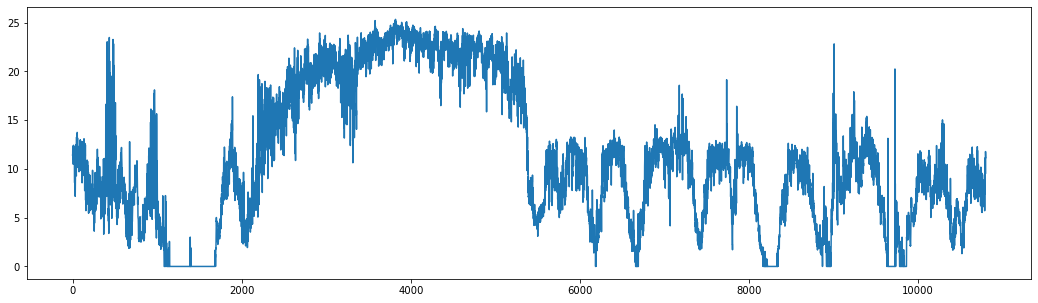

In [22]:
t_preds,_ = learn.get_preds(ds_type=DatasetType.Test)

plt.figure(figsize=(18,5))
plt.plot(t_preds.squeeze()); None

In [27]:
t_df = pd.DataFrame(t_preds.numpy())
t_df.to_csv(OUT_PATH/'test_preds.csv', index=False)